In [12]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from numpy import loadtxt
from keras.models import load_model, model_from_json
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
import json
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

In [13]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [14]:
with open('/Users/maggiezhang/Downloads/cnntonnencoder.json','r') as f:
    model_encoder_json = json.load(f)
    model_encoder_json = json.dumps(model_encoder_json)
    model_encoder_json = str(model_encoder_json)

model_encoder = model_from_json(model_encoder_json)
model_encoder.load_weights('/Users/maggiezhang/Downloads/cnntonnencoder.h5')
model_encoder.summary()

with open('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/model.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('/Users/maggiezhang/Desktop/2019-2020/atmosphereModel/NeuralNetworkCode/Models/model.h5')
model_NN.summary()

with open('/Users/maggiezhang/Downloads/cnntonndecoder.json','r') as f:
    model_decoder_json = json.load(f)
    model_decoder_json = json.dumps(model_decoder_json)
    model_decoder_json = str(model_decoder_json)

model_decoder = model_from_json(model_decoder_json)
model_decoder.load_weights('/Users/maggiezhang/Downloads/cnntonndecoder.h5')
model_decoder.summary()




Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 24, 20, 1, 6)      222       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 7, 6, 1, 12)       2172      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 3, 3, 1, 12)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 108)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10900     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                101

In [15]:
"""Load data for full NN architecture"""
years = 1
base_year = 2000

data_header = "/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/"

for i in range(years):
    file_name_density = str(base_year+i) + "_JB2008_density.mat"
    file_name_SW = str(base_year+i) + "_JB2008_sw.mat"
    dens = scipy.io.loadmat(data_header+file_name_density)
    sw = scipy.io.loadmat(data_header+file_name_SW)


In [22]:
"""Compress data using ROM method"""
r = 10

localSolarTimes = np.linspace(0,24,24)
latitudes = np.linspace(-87.5,87.5,20)
altitudes = np.linspace(100,800,36)
nofAlt = len(altitudes)
nofLst = len(localSolarTimes)
nofLat = len(latitudes)
denseData = dens['densityData']
spacewData = sw['SWdata']
densityDataMeanLog = np.log10(np.mean(denseData, axis = 1))
densityDataMeanLog = np.reshape(densityDataMeanLog, (17280, 1))
densityDataVarLog = np.log10(denseData) - densityDataMeanLog
u,d,v = np.linalg.svd(densityDataVarLog)
densityDataLogVarROM = np.matmul(np.transpose(u[:,0:r]), densityDataVarLog)
startIndex = 0

X1 = densityDataLogVarROM[0:r, startIndex: -1]
X2 = densityDataLogVarROM[0:r, startIndex+1:]

# standard space weather inputs for the linear model
U1 = np.transpose(spacewData[startIndex:-1,:])
#print(U1.shape)
# add next timesteps for better prediction
U1 = np.append(U1,np.transpose(spacewData[startIndex+1:,10:11]), axis = 0)
#print(U1[14:15, 0:5])
U1 = np.append(U1,np.transpose(spacewData[startIndex+1:,2:3]), axis = 0)
U1 = np.append(U1,np.transpose(spacewData[startIndex+1:,4:5]), axis = 0)
U1 = np.append(U1,np.transpose(spacewData[startIndex+1:,6:7]), axis = 0)
U1 = np.append(U1,np.transpose(spacewData[startIndex+1:,8:9]), axis = 0)
#adding mixed terms
#rand = np.matmul(np.transpose(spacewData[startIndex:-1,10:11]),np.transpose(spacewData[startIndex:-1,2:3]))
#print(rand.shape)
U1 = np.append(U1,(np.multiply(np.transpose(spacewData[startIndex:-1,10:11]),np.transpose(spacewData[startIndex:-1,2:3]))), axis = 0)
U1 = np.append(U1,(np.multiply(np.transpose(spacewData[startIndex+1:,10:11]),np.transpose(spacewData[startIndex+1:,2:3]))), axis = 0)

#adding quadratic DSTDTC 
U1 = np.append(U1,np.transpose(np.square((spacewData[startIndex:-1,10:11]))), axis = 0)
U1 = np.append(U1,np.transpose(np.square((spacewData[startIndex+1:,10:11]))), axis = 0)

Om = np.append(X1, U1, axis = 0)
Phi = np.matmul(X2,np.linalg.pinv(Om))
A = Phi[:r, :r]
B = Phi[:r, r:]
a,b = np.linalg.eig(A)
XfullPred = np.matmul(A,X1) + np.matmul(B,U1)


In [42]:
xdata = dens['densityData'].T
xdata=xdata.astype('float32')
print(xdata.shape)

xmat=(xdata - np.mean(xdata, keepdims=True)) / np.std(xdata, keepdims=True)
print(xmat.shape)
actual_predict = xmat[1:,:]

xmat = np.reshape(xmat, (8784, 24,20,36,1))

xdata = xdata[:-1, :]
xtest = xmat[:-1,:,:,:,:]
ytest = xmat[1:,:,:,:,:]
print(ytest.shape)
print(xmat.shape)

swmat = sw['SWdata']
swtest = swmat[:-1,:]
swappend = swmat[1:,:]
swtest= np.concatenate((swtest, swappend), axis=1)
print(swtest.shape)

(8784, 17280)
(8784, 17280)
(8783, 24, 20, 36, 1)
(8784, 24, 20, 36, 1)
(8783, 28)


In [31]:
Om = np.append(np.transpose(xdata), np.transpose(swtest), axis = 0)
X2 = np.transpose(ytest)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

In [56]:
swmat = sw['SWdata']
swtest = swmat[:-1,:]
swappend = swmat[1:,:]
swtest= np.concatenate((swtest, swappend), axis=1)
X1_lin = X1.T
Lin_NN_Data = np.concatenate((X1_lin, swtest), axis=1)
print(Lin_NN_Data.shape)
Lin_NN_predict = model_NN.predict(Lin_NN_Data).T

print(Lin_NN_predict.shape)
densityVarRomPred= np.matmul(u[:,:r], Lin_NN_predict)
print(densityVarRomPred.shape)
matrixof10 = np.full((17280, 8783), 10)
densityRomPred = np.power(matrixof10,(densityVarRomPred+densityDataMeanLog))
xdata = dens['densityData'].T
xdata=xdata.astype('float32')
actual_ROM = xdata[1:,:].T

print(actual_ROM.shape)
squared_ROM = np.sum(np.square(densityRomPred-actual_ROM))/(actual_ROM.shape[0]*actual_ROM.shape[1])
print(squared_ROM)



(8783, 38)
(10, 8783)
(17280, 8783)
(17280, 8783)
3.5702848869347455e-16


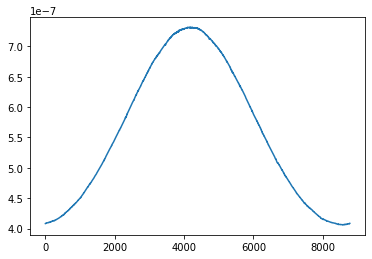

In [76]:
plt.figure()
plt.plot(actual_ROM[0])

In [77]:
"""Predicting using all 3 models"""

rom_predict = model_encoder.predict(xtest)

# add space weather to the rom prediction
NN_data = np.concatenate((rom_predict, swtest), axis=1)

NN_predict = model_NN.predict(NN_data)

final_predict = model_decoder.predict(NN_predict)
final_predict = model_decoder.predict(Lin_NN_predict.T)
final_predict = model_decoder.predict(XfullPred.T)


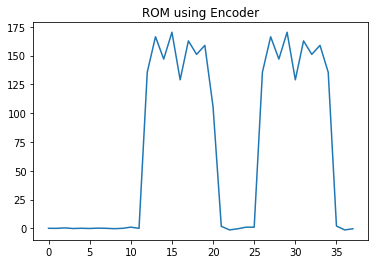

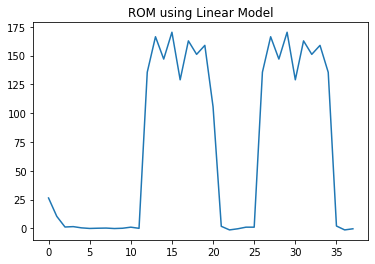

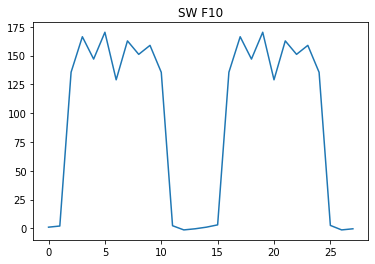

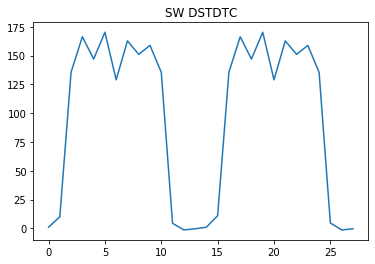

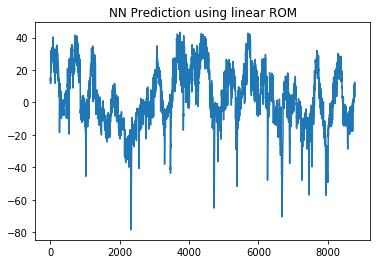

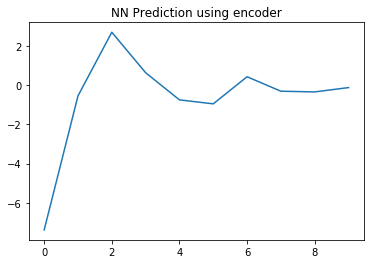

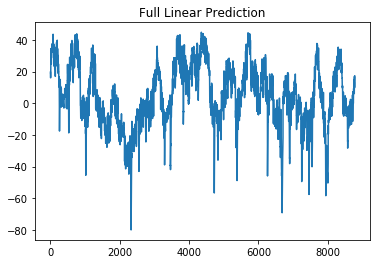

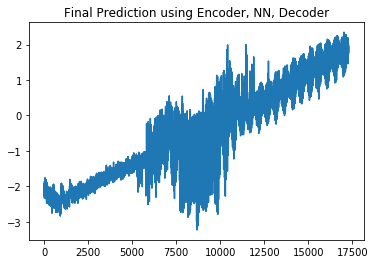

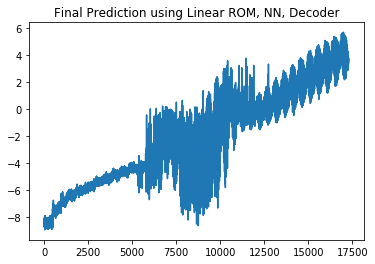

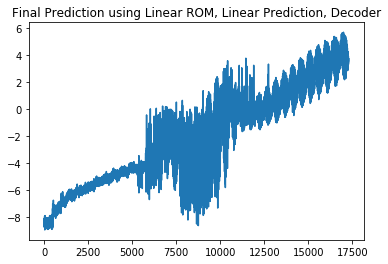

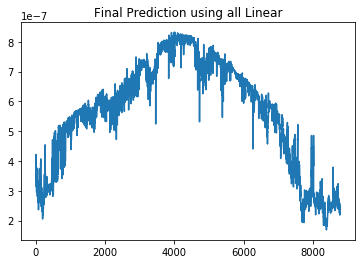

In [78]:
"""Graphs of Data"""

#Encoder
plt.figure()
plt.title("ROM using Encoder")
plt.plot(NN_data[0])
plt.figure()
plt.title("ROM using Linear Model")
plt.plot(Lin_NN_Data[0])
plt.figure()
plt.title("SW F10")
plt.plot(swtest[2])
plt.figure()
plt.title("SW DSTDTC")
plt.plot(swtest[10])

#NN
plt.figure()
plt.title("NN Prediction using linear ROM")
plt.plot(Lin_NN_predict[0])
plt.figure()
plt.title("NN Prediction using encoder")
plt.plot(NN_predict[0])
plt.figure()
plt.title("Full Linear Prediction")
plt.plot(XfullPred[0])

#Decoder
plt.figure()
plt.title("Final Prediction using Encoder, NN, Decoder")
plt.plot(final_predict[0])
plt.figure()
plt.title("Final Prediction using Linear ROM, NN, Decoder")
plt.plot(final_predict_lin[0])
plt.figure()
plt.title("Final Prediction using Linear ROM, Linear Prediction, Decoder")
plt.plot(final_predict_lin[0])
plt.figure()
plt.title("Final Prediction using all Linear")
plt.plot(densityRomPred[0])

In [43]:
print(final_predict[:10,1])
print(actual_predict[:10,1])
squared = np.sum(np.square(final_predict-actual_predict))/(final_predict.shape[0]*final_predict.shape[1])
percent_error = (final_predict-actual_predict)/actual_predict
rms_matrix = np.zeros(percent_error.shape[0])
for i in range(len(percent_error)):
    rms_matrix[i] = (np.sum(np.square(percent_error[i])))**(0.5)
print(np.mean(rms_matrix))
rms_percent = (np.sum(np.square(percent_error))/(percent_error.shape[0]*percent_error.shape[1]))**(1/2)
print(percent_error)
print(rms_percent)
print(squared)

[-0.95544744 -0.550004   -0.549598   -0.6550026  -0.5610564  -0.56062984
 -0.560204   -0.5597758  -0.5593498  -0.71144557]
[4.301458  4.301596  4.3017354 4.301141  4.3012815 4.3014226 4.3015647
 4.3017073 4.3018503 4.302729 ]
723.3504681116718
[[-1.1926072 -1.2221218 -1.2035104 ... -3.8083432 -3.9982257 -3.6433992]
 [-1.1099892 -1.1278604 -1.1198654 ... -1.0352243 -1.0389681 -1.0214396]
 [-1.109891  -1.127762  -1.1197665 ... -1.0344075 -1.0380414 -1.0206556]
 ...
 [-1.0883416 -1.1071318 -1.0986391 ... -1.2387276 -1.2668854 -1.2322637]
 [-1.2104287 -1.2261246 -1.2230039 ... -3.1584153 -3.099397  -3.0840597]
 [-1.0827692 -1.1014513 -1.0929168 ... -1.2018687 -1.233254  -1.1965947]]
5.888340467377545
1.824873176717649


In [27]:
"""Compare errors between the final prediction and the actual data for all these years """

#XfullPred = XfullPred.T
#print(XfullPred.shape)
error_Lin_NN = 0
error_CNN_NN = 0

print(Lin_NN_predict.shape)
for i in range(len(XfullPred)):
    for j in range(len(XfullPred[0])):
        error_Lin_NN += (Lin_NN_predict[i][j] - NN_predict[i][j])**2
        error_CNN_NN += (XfullPred[i][j] - NN_predict[i][j])**2
error_Lin_NN = error_Lin_NN /(XfullPred.shape[0]*XfullPred.shape[1])
error_CNN_NN = error_CNN_NN /(XfullPred.shape[0]*XfullPred.shape[1])
print(error_Lin_NN)
print(error_CNN_NN)


        

(8783, 10)
80.29831358326653
80.92667468059855
